## Basic Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
# bulding a mock datatset 
X, y = make_classification(n_samples = 1000, n_features = 100, 
                           n_informative = 11, n_redundant = 35,n_classes=2) # auc throws error when there are only two classes

groups = np.repeat(np.arange(10), 100) # creatng random groups

In [3]:
# defining a model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, KFold

# we will use ColinearityRemover to discard redundant features
from crlearn.transformers import DropColinCV

cv = GroupKFold(n_splits = 5)

model = Pipeline([
    ('scaling', StandardScaler()),
    ('linear_fs', DropColinCV()),
    ('estimator', LogisticRegression(solver ='saga'))
])

param_grid = {
    'estimator__C': [.0001, .001, .01, .1],
    'estimator__penalty': ['l1','l2']
}

optimizer = GridSearchCV(model, param_grid, cv = cv)

In [4]:
from crlearn.evaluation import crossvalidate_classification
# nested crossvalidation in one line
scores, _, _ = crossvalidate_classification(optimizer, X, y,groups=groups,cv = cv, name="nested_crossvalidation")

nested_crossvalidation: 100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


In [5]:
# major scores
scores["metrics"].groupby(["side","class"]).agg(['mean','std']).T

# scores contains major classification scores for each classification fold and each class.
# Thus, compared to sklearn cross_validate it computes also disaggregated class scores.
# In this case, our model work well, scores are stable and balanced between class 0 and 1 across all metrics. 

side                 test                   train            
class                   0           1           0           1
f1        mean   0.782034    0.783925    0.812769    0.815157
          std    0.018934    0.022698    0.005560    0.006587
recall    mean   0.781779    0.785548    0.810731    0.817190
          std    0.027812    0.039191    0.011141    0.011745
precision mean   0.783691    0.783678    0.814937    0.813252
          std    0.036931    0.029884    0.007680    0.008355
auc       mean   0.868703    0.868703    0.892402    0.892402
          std    0.014119    0.014119    0.005537    0.005537
support   mean  99.600000  100.400000  398.400000  401.600000
          std    3.361547    3.361547    3.361547    3.361547
balance   mean   0.498000    0.502000    0.498000    0.502000
          std    0.016808    0.016808    0.004202    0.004202

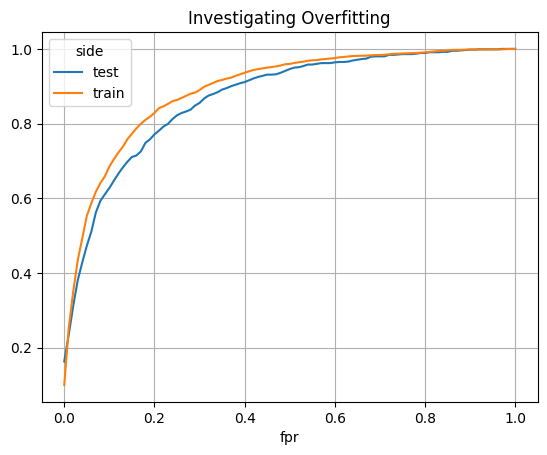

In [6]:
# ROCS in one line
# let's compare training and testing performance 
_=scores["rankings"]["roc_curves"].groupby(["side",'fpr']).mean().mean(axis=1).unstack().T.plot(grid=True,title="Investigating Overfitting")

# similarly to scores, in rocs you will find FPR and TPR for each crossvalidation fold.

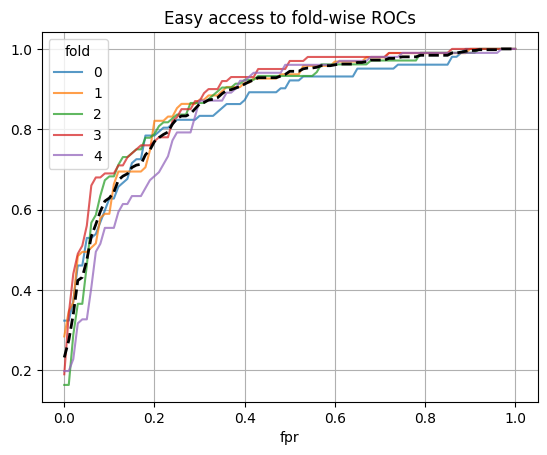

In [7]:
# in rocs you can eaily compute ROC for each fold to assess the stability of trained models.
ax = scores["rankings"]["roc_curves"].query("side=='test'").reset_index().set_index(["fold","fpr"])[1].unstack().T.plot(title = 'Easy access to fold-wise ROCs', alpha = .75)
_ = scores["rankings"]["roc_curves"].query("side=='test'").groupby('fpr').mean()[1].plot(ax = ax, color = 'k', lw = 2, ls = '--',grid=True)

# the black dotted line is the average ROC across folds 